In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
import time

from functions import strip_first_col
from functions import Tree_geometry
from functions import ERT_position
from functions import error_calc
from functions import create_starting_model_2D
from functions import med_u_i


start = time.time()
tree = 'Tree835_1_220511_morning'
hardwood_radius = 0.094884

################################################################################
# 0) Read geometry and data file and Write data for BERT Inversion

# TO DO BEFORE ##################################################################
# geometry.txt: change , with tab/space separation between columns              #
# measured_values.csv: save as .txt + delete first row (the one with letters)   #
################################################################################

GEOM = np.loadtxt('geometry_835.txt')
nel = GEOM.shape[0]  # n° of electrodes
height = 1.0  # height of the tree
zel = 0.  # electrodes z coordinates
DATA = np.loadtxt(strip_first_col('220511_Tree_nr_835_1.txt'))
N = DATA.shape[0]  # n° of data points
med_u, med_i = med_u_i('220511_Tree_nr_835_1.txt', '220511_Tree_nr_835_2.txt', '220511_Tree_nr_835_3.txt')
err, med_rhoa, sign1, sign2, std1, std2, mean1, mean2, std = error_calc('220511_Tree_nr_835_1.txt','220511_Tree_nr_835_2.txt', '220511_Tree_nr_835_3.txt')

#create Dataset from geometry and measured data:
with open('Tree_Dataset_835_morning_220511_1_test.dat', 'w') as f:  #
    f.write('%d' % nel + '\n')  #
    f.write('# ' + 'x ' + 'y ' + 'z ' + '\n')  #
    for i in range(nel):  #
        f.write('%.5f ' % GEOM[i, 1] + '%.5f ' % GEOM[i, 2] + '%.5f ' % zel + '\n')  #
    # write data                                                                                                                                                                            #
    f.write('%d' % N + '\n')  #
    f.write('# ' + 'a ' + 'b ' + 'm ' + 'n '+ 'u ' + 'i ' + '\n')  #
    for i in range(N):  #
        f.write('%d ' % DATA[i, 0] + '%d ' % DATA[i, 1] + '%d ' % DATA[i, 2] + '%d ' % DATA[i, 3] + '%.6f ' % np.abs(DATA[i, 5]) + '%.6f ' % DATA[i, 4] + '\n')  #
    f.write('%d' % 0)  #
f.close()  #
#########################################################################################################################################################################################

In [9]:
area = 0.1  # maximum cell size for resulting triangles after mesh generation
quality = 35  # minimum angle of mesh-triangles (increasing this reduces refinement)
center_pos, Tree_Geom = Tree_geometry(GEOM, area, quality, height)
DataSet = ert.load('Tree_Dataset_835_morning_220511_1_test.dat')
starting_model_2D, mesh_2D, mesh_2D_hom = create_starting_model_2D(center_pos, DataSet, hardwood_radius)

Parameter value 180.0 assigned to cell marker 1
Parameter value 1340.0 assigned to cell marker 2


In [10]:
Homogeneous = ert.simulate(mesh_2D_hom, res=1, scheme=DataSet, sr=False, calcOnly=True, verbose=True)

k = 1 * Homogeneous('i') / Homogeneous('u')
DataSet["k"] = k

DataSet["rhoa"] = (DataSet['u'] / DataSet['i']) * -k

DataSet.set('err', pg.Vector(len(med_u), 0.05))
DataSet.remove(DataSet["rhoa"] < 20)

DataSet.save('Tree_Dataset_GF_morning_220511_1_test.dat', 'a b m n err rhoa k u i')
##################################################################################################################################################

Found: export BERTTHREADS=8
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 18 electrodes
Found: 18 free-electrodes
Found: 1 reference electrode node.
Found: 1 calibration node.
rMin = 0.0255004, rMax = 0.670739
NGauLeg + NGauLag for inverse Fouriertransformation: 8 + 4
Found non-Neumann domain
Non-Neumann domain conflicts with given calibration point. Ignoring calibration.
0.006 s
FOP updating mesh dependencies ... 0 s
Forward: time: 0.062s


1

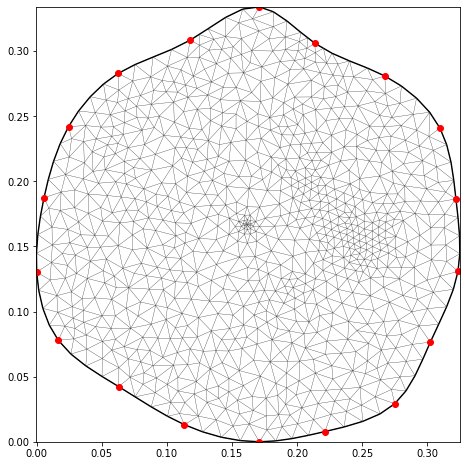

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
pg.show(mesh_2D_hom, ax=ax)
ax.plot(pg.x(DataSet.sensorPositions()), pg.y(DataSet.sensorPositions()), "ro")

In [12]:
ert_2D_het = ert.ERTManager(sr=False)
inv_2D_het = ert_2D_het.invert(DataSet, mesh=mesh_2D_hom, lam=20, verbose=True)

05/08/22 - 22:04:42 - pyGIMLi - INFO - Found 1 regions.
05/08/22 - 22:04:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
05/08/22 - 22:04:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
05/08/22 - 22:04:42 - pyGIMLi - INFO - Use median(data values)=4990.621460383017
05/08/22 - 22:04:42 - pyGIMLi - INFO - Created startmodel from forward operator: 1673 [4990.621460383017,...,4990.621460383017]
05/08/22 - 22:04:42 - pyGIMLi - INFO - Starting inversion.


Non-Neumann domain conflicts with given calibration point. Ignoring calibration.
min/max(dweight) = 20/20
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7ff748a2c630>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7ff748a24ae0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7ff748a2c590>
min/max (data): 29.21/7.3e+04
min/max (error): 5%/5%
min/max (start model): 4991/4991
--------------------------------------------------------------------------------
Calculating response for model: min = 4990.62 max = 4990.62
Forward: time: 2.77s
Response: min = 4978.57 max = 5116.46 mean = 5010.85
Reciprocity rms(modelReciprocity) 0%, max: 0%
min/max(dweight) = 20/20
Building constraints matrix
constraint matrix of size(nBounds x nModel) 2472 x 1673
check Jacobian: wrong dimensions: (0x0) should be (135x1673)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...Using existing subpotentials for createJaco

Text(0.5, 1.0, 'Model response\n')

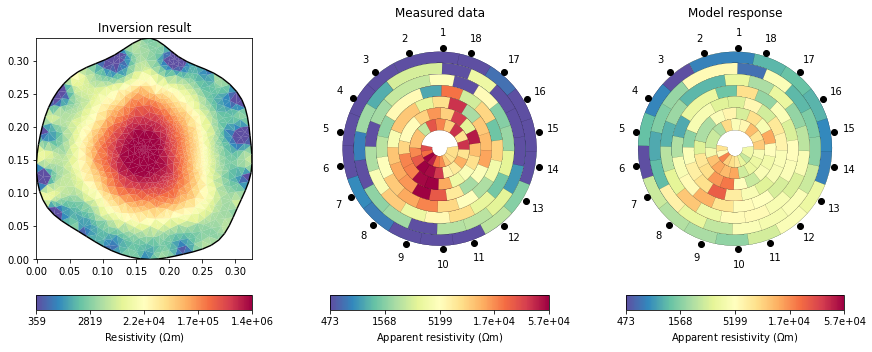

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
min_model, max_model = pg.utils.interperc(ert_2D_het.model, islog=True)
pg.show(ert_2D_het.paraDomain, ert_2D_het.model, logScale=True, ax=ax1, label=pg.unit("res"), cMap="Spectral_r", cMin=min_model, cMax=max_model)
ax1.set_title("Inversion result")

min_data, max_data = pg.utils.interperc(DataSet["rhoa"])
ax2.set_title("Measured data\n")
pg.show(DataSet, vals=DataSet["rhoa"], circular=True, ax=ax2, cMin=min_data, cMax=max_data)
pg.show(DataSet, vals=ert_2D_het.inv.response, circular=True, ax=ax3, cMin=min_data, cMax=max_data)
ax3.set_title("Model response\n")

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7ff74409b0a0>)

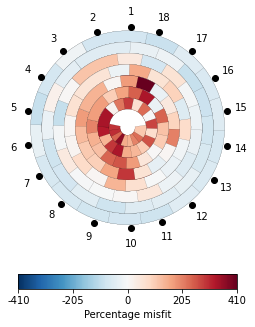

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
rrms = ert_2D_het.inv.relrms()
pg.show(DataSet, vals=(DataSet["rhoa"]-ert_2D_het.inv.response)/ert_2D_het.inv.response * 100, circular=True, cMap="RdBu_r", cMin=-rrms, cMax=rrms, ax=ax, label="Percentage misfit")

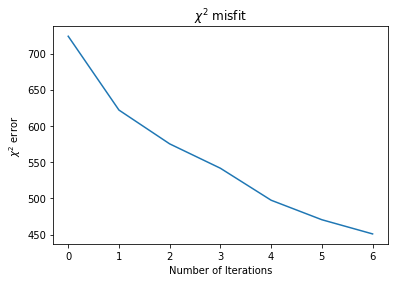

In [15]:
chi2_2D_het = ert_2D_het.inv.chi2History

plt.figure(3)
plt.plot(chi2_2D_het)
plt.xlabel('Number of Iterations')
plt.ylabel(r'$\chi^2$ error')
plt.title(r'$\chi^2$ misfit')
plt.show()